# Dogs vs Cats classification using transfer learning and CNN

This kernel shows how to use transfer learning to classify dogs and cats images. If you find this kernel useful please upvote it!

Transfer learning means that instead of your model learning everything from scratch, it uses another model that was trained on a similar problem, so that you can "transfer" the learned "knowledge" of the pretrained model to your model, and then learn some new features.

The ImageNet Data set is huge data set consisting of more that 14 million images from more than 22,000 different categories, here we are using a smaller version of it which has 1000 different categories.

In this kernel we use an xception model which is pretrained on the ImageNet dataset and then build some layers on top of it to be able to classify dogs and cats images.

Transfer learning makes sense here because the ImageNet data set has a much larger number of images (14 million) than the dog-cat data set (25,000). This increases the speed of training of our model and the accuracy of our predictions.

# Import Required Libraries


In [1]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical

print('setup successful!')

setup successful!


# Define Constants

In [2]:
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3

# The image net have 1000 categories, and so 1000 outputs, so we get 1000 different features
IMAGE_FEATURES_SIZE = 1000

# For the first run PERFORM_UNZIPPING must be True, but after the first run, 
#it can be set to False skip the unzipping step to save time
PERFORM_UNZIPPING = True 

print('defining constants successful!')

defining constants successful!


# Unzip the Train and Test folders

The train and test folders are zipped, the code below unzips both folders and the unzipped folders are saved in the output folder. For the First run PERFORM_UNZIPPING should be true to perform the unzipping, later if the folders are already unzipped you can change it to False

In [3]:
if PERFORM_UNZIPPING == True:
    #Unzip the input folders
    with zipfile.ZipFile("../input/dogs-vs-cats-redux-kernels-edition/train.zip","r") as z:
        z.extractall(".")        
    
    with zipfile.ZipFile("../input/dogs-vs-cats-redux-kernels-edition/test.zip","r") as z:
        z.extractall(".")   
    
    print('Unzipping done!')
    
    
else:
    print('Unzipping not needed')
    
    
imgs_path = "/kaggle/working/train/"
realtestimgs_path = "/kaggle/working/test/"

Unzipping done!


# Prepare load_image function and Data Frame
The pretrained model that we are using here is the xception model. The advantage of the xception model is that it has a small size, relatively small number of parameters and high accuracy. You can have a look with on a comparison of different pretrained models available in Keras in https://keras.io/api/applications/


The function 'load_image' takes the path of an image as an input and return the preprocessed image. 


In [4]:
def _load_image(img_path):
    img = image.load_img(img_path, target_size = (IMAGE_WIDTH, IMAGE_HEIGHT)) # load the image from the directory
    img = image.img_to_array(img) 
    # add an additional dimension, (i.e. change the shape of each image from (224, 224, 3) to (1, 224, 224, 3)
    # This shape is suitable for training
    img = np.expand_dims(img, axis = 0) 
    # Apply preprocessing for the image, so that the training is faster
    img = xception.preprocess_input(img)
        
    return img

Create a  dataframe that contains a list of the file names and the corresponding category. Category 1 means dog, 0 means cat

In [5]:
filenames = os.listdir(imgs_path)

categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print(df.head())

print('number of elements = ' , len(df))

        filename  category
0    cat.947.jpg         0
1  dog.11484.jpg         1
2   cat.8760.jpg         0
3   dog.8512.jpg         1
4   dog.3420.jpg         1
number of elements =  25000


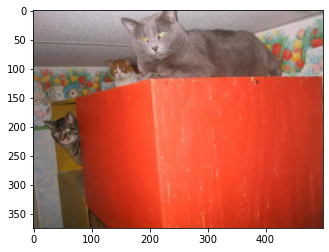

In [6]:
# see sample image, you can run the same cell again to get a different image
sample = random.choice(filenames)
randomimage = image.load_img(imgs_path + sample)
plt.imshow(randomimage)

# Create the Pretrained Model
There are two approaches for transfer learning:
1. One model where the first part of it is the pretrained model and the second part is your new model. 
1. Pass all the images through the pretrained model, to get the extracted features and then use those extrated features to    train your new model. 

Here we will use the second approach (the feature extraction approach), because a matrix which contains all our images with the shape (224, 224, 3) will not fit in our RAM. So we first pass all the images through the xception model and get the extracted features, as mentioned above the model has 1000 categories, so the output will have a size of 1000 which is much smaller than (224 X 224 X 3 = 150,528) . So if we have 100 images the tarining matrix will have a shape of (100, 1000)

In [7]:
# create the xception model used for the feature extraction
model_xception = xception.Xception(include_top = True, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = '../input/xception/xception_weights_tf_dim_ordering_tf_kernels.h5')

We will use the EarlyStopping call back to stop our training  if the accuracy is not improving for a certain number of epochs. 
If the accuracy is not improving for a certain number of epochs then it makes sense to reduce the learning rate, we implement that using the ReduceLROnPlateau call back.

In [8]:
# Define call backs
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(patience = 7, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(patience = 3, verbose = 1, factor=0.5)

print('call backs defined!')

call backs defined!


# Feature Extraction
The extract_features function will take the pretrained model used for feature extraction and a batch of images, then it will pass those images through the model to obtain the extracted features. It is better to pass a maximum of a round 1000 images at a time in order not to fill our RAM. The data_set parameter is dataframe containing filenames and the corresponding categories for each file.

In [9]:
def extract_features(model, data_set):
    
    loaded_images = np.zeros((len(data_set), IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
        
    for i, data_set_entry in enumerate (data_set):
        file_name = data_set_entry[0]
        category  = data_set_entry[1]
        path = imgs_path + file_name        
        loaded_img = _load_image(path)
        loaded_images[i, :, :, :] = loaded_img

    preds = model.predict(loaded_images)   
    
    return preds

We split the training set into three separate sets:
1. **The training set**: used to train our model.
2. **The validation set**: used to double check that our model is not overfitting the training set, i.e. it can also generalise    to other data other than the train data
3. **The Test set**: Used to estimate the accuracy of the model on new data other than the ones the model used for training

For a competetion or for some other cases, you can split the data only to training and validation sets inorder to acheive te highest possible accuracy, without the need to properly estimate how accurate the model really is.

We split the data set as follows: 2% test set, 82% train set, 16% cross_validation set
 


shape of train_set:    (20500, 2)
shape of validate_set: (3500, 2)
shape of test_set:     (1000, 2)


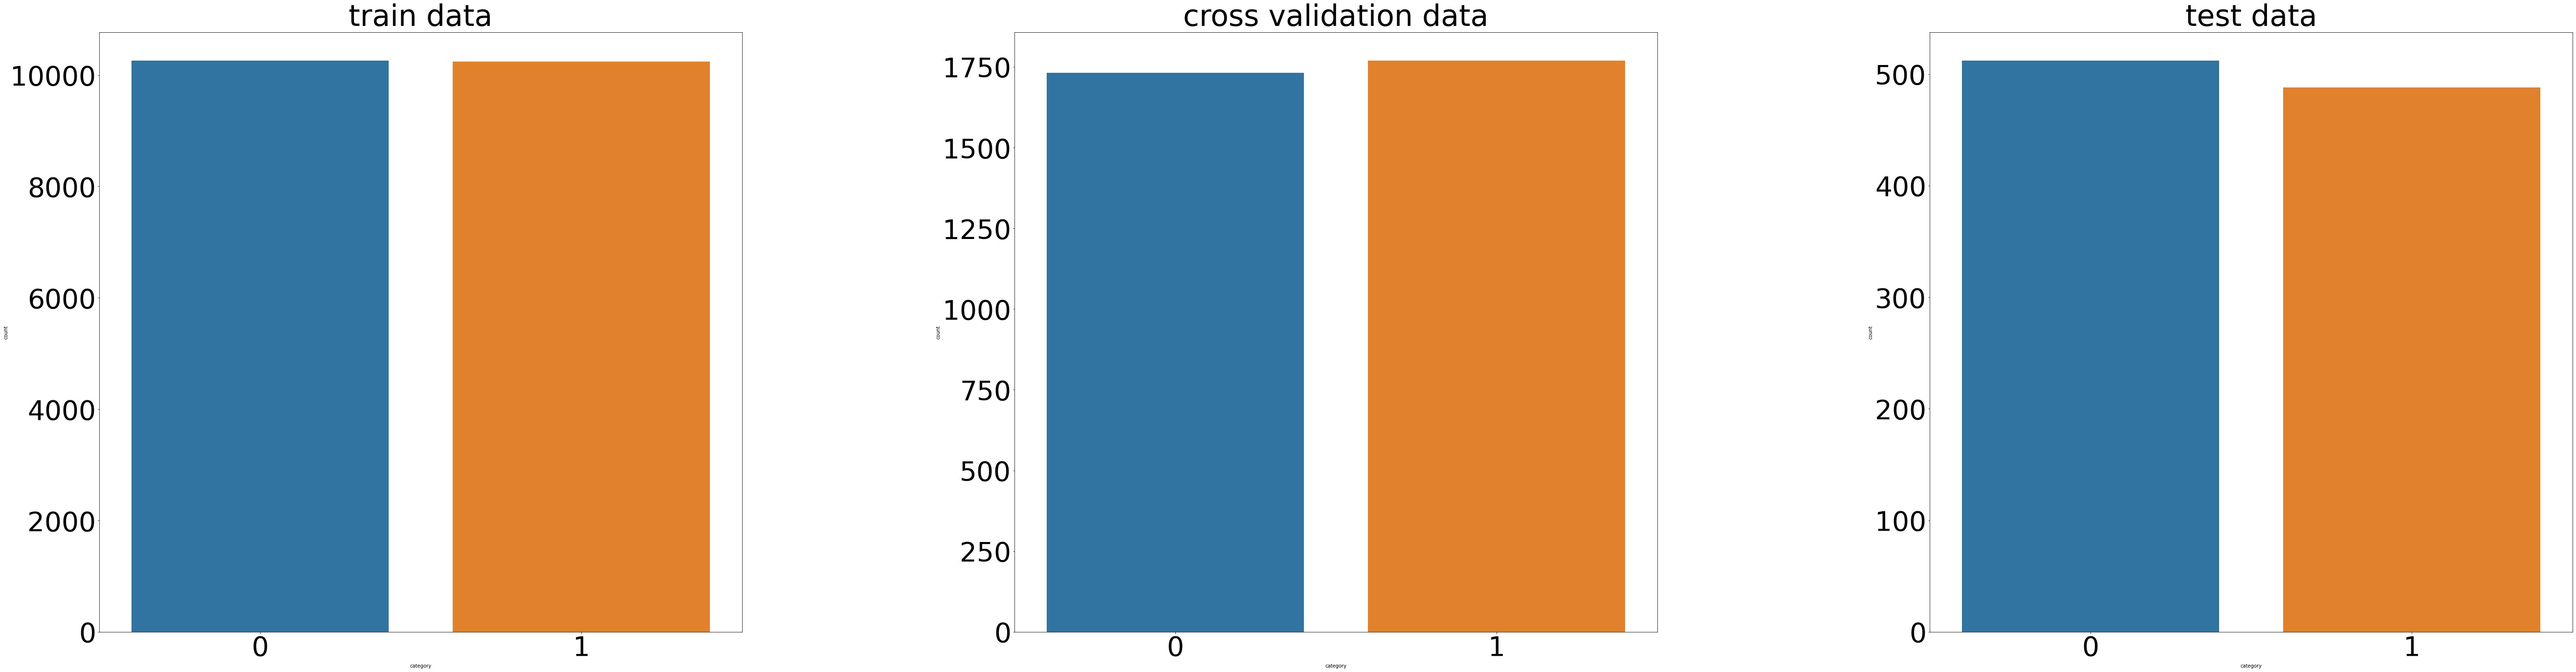

In [10]:
train_set, validate_set, test_set = np.split(df.sample(frac=1, random_state =43), [int(.82*len(df)), int(.96*len(df))])

# Visualize the data distribution
fig, axis = plt.subplots(1,3)
fig.tight_layout()
fig.set_size_inches(80,20)

ax0 = sns.countplot(data=train_set   , x = 'category', ax = axis[0])
ax1 = sns.countplot(data=validate_set, x = 'category', ax = axis[1])
ax2 = sns.countplot(data=test_set    , x = 'category', ax = axis[2])

ax0.set_title('train data', fontsize = 60)
ax1.set_title('cross validation data', fontsize = 60)
ax2.set_title('test data', fontsize = 60)

ax0.tick_params(labelsize=55)
ax1.tick_params(labelsize=55)
ax2.tick_params(labelsize=55)

print('shape of train_set:   ', np.shape(train_set))
print('shape of validate_set:', np.shape(validate_set))
print('shape of test_set:    ', np.shape(test_set))


# convert the dataframes to numpy matrices
train_set    = train_set.to_numpy()
validate_set = validate_set.to_numpy()
test_set     = test_set.to_numpy()

Now we perform the feature extraction. We take chunks of the train_set (1000 at a time) and pass them through the pretrained model, and save the extracted features in train_x. We then do the same with the validation_set.

In [11]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
# prepare parameters for model.fit
train_x = np.zeros((len(train_set), 1000)) 
train_y = np.zeros((len(train_set)))

validate_x = np.zeros((len(validate_set), 1000)) 
validate_y = np.zeros((len(validate_set) ))

chunk_size = 1000

# extract features from train_set nd save it into train_x
for i, train_set_chunk in enumerate (chunks(train_set, chunk_size)):
    train_x[ (i*chunk_size) : (i*chunk_size + chunk_size)] = extract_features(model_xception, train_set_chunk)    

print('shape of train_x: ',    np.shape(train_x))


# extract features from validate_set nd save it into validate_x
for i, validate_set_chunk in enumerate (chunks(validate_set, chunk_size)):
    validate_x[ (i*chunk_size) : (i*chunk_size + chunk_size)] = extract_features(model_xception, validate_set_chunk)    

print('shape of validate_x: ', np.shape(validate_x))

shape of train_x:  (20500, 1000)
shape of validate_x:  (3500, 1000)


We take the second column from the train_set (the category column) and save it in train_y. We then convert it to a one-hot vector using the "to_categorically" method, we need the one-hot format for the model fitting later on.

In [12]:
# prepare train_y
train_y = train_set[:,1]
train_y = to_categorical(train_y)        

# prepare validate_y
validate_y = validate_set[:,1]
validate_y = to_categorical(validate_y)   

# Build the new model and train it
Note that it is a small model, that is because it doesn't need to learn everything from scratch because we are using the extracted features. Also learning will take just around 30 seconds using the GPU.

In [13]:
transfer_model = Sequential()

transfer_model.add(keras.Input(shape = (IMAGE_FEATURES_SIZE)))
transfer_model.add(Flatten())
transfer_model.add(Dense(100, activation = 'relu'))
transfer_model.add(Dense(16,  activation = 'relu'))
transfer_model.add(Dense(2,   activation = 'softmax')) # The last layer has 2 units beacuse we have 2 classes (Dog and cat)

transfer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               100100    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 101,750
Trainable params: 101,750
Non-trainable params: 0
_________________________________________________________________


In [14]:
# compile and fit the model
transfer_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

EPOCHS = 20

history = transfer_model.fit(x = train_x , y= train_y, batch_size = 16, epochs = EPOCHS, 
                             callbacks = [early_stop, learning_rate_reduction],
                             validation_data = (validate_x, validate_y))

Epoch 1/20
1282/1282 [==============================] - 4s 3ms/step - loss: 0.1137 - accuracy: 0.9684 - val_loss: 0.0758 - val_accuracy: 0.9740
Epoch 2/20
1282/1282 [==============================] - 4s 3ms/step - loss: 0.0723 - accuracy: 0.9748 - val_loss: 0.0734 - val_accuracy: 0.9766
Epoch 3/20
1282/1282 [==============================] - 3s 3ms/step - loss: 0.0665 - accuracy: 0.9776 - val_loss: 0.0782 - val_accuracy: 0.9771
Epoch 4/20
1282/1282 [==============================] - 3s 2ms/step - loss: 0.0621 - accuracy: 0.9785 - val_loss: 0.0750 - val_accuracy: 0.9769
Epoch 5/20
1263/1282 [============================>.] - ETA: 0s - loss: 0.0587 - accuracy: 0.9796
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1282/1282 [==============================] - 4s 3ms/step - loss: 0.0590 - accuracy: 0.9794 - val_loss: 0.0768 - val_accuracy: 0.9783
Epoch 6/20
1282/1282 [==============================] - 3s 3ms/step - loss: 0.0536 - accuracy: 0.9818 - val_loss:

In [15]:
transfer_model.save_weights("model.h5")

# Visualize the training process

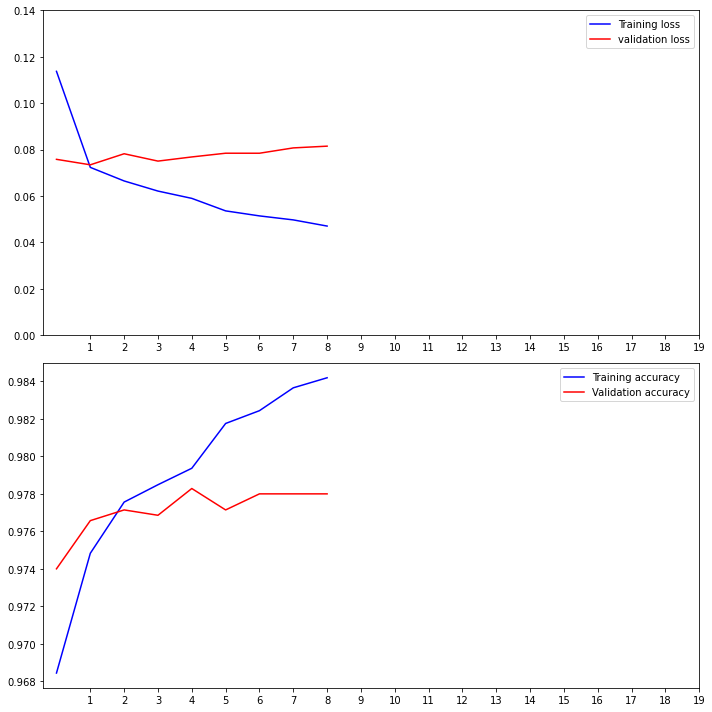

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 0.14, 0.02))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Predict
Predict the class for the test set and evaluate the accuracy on the test set.

In [17]:
test_x = np.zeros((len(test_set), 1000)) 
test_y = np.zeros((len(test_set) ))

# extract features from test_set and save it into test_x
for i, test_set_chunk in enumerate (chunks(test_set, chunk_size)):
    test_x[ (i*chunk_size) : (i*chunk_size + chunk_size)] = extract_features(model_xception, test_set_chunk)    

# prepare test_y
test_y = test_set[:,1]
test_y = to_categorical(test_y) 

assert(np.shape(test_y)  == (np.shape(test_set)[0], 2))

# predict and estimate the accuracy
_, accuracy = transfer_model.evaluate(test_x, test_y)   
print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

32/32 [==============================] - 0s 2ms/step - loss: 0.0733 - accuracy: 0.9820
accuracy on test set =  98.2 % 


# Predict Class of Random Image
The cell below will randomly select an image from the test set, predict if it is a dog or cat. You can run the cell several times to get different images.

I am 99% sure that I am a dog!


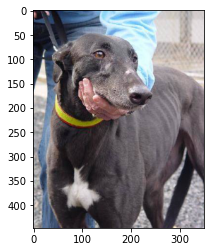

In [18]:
sample = random.choice(test_set)[0]
randomimage = image.load_img(imgs_path + sample)
plt.imshow(randomimage)

loaded_image = _load_image(imgs_path + sample)
extracted_feat = model_xception.predict(loaded_image) 
pred = transfer_model.predict(extracted_feat)

pred = pred[0]  # convert to array
if pred[0] >= pred[1]:
    prediction_class = 'cat'
    prediction_percentage = pred[0]
else:
    prediction_class = 'dog'
    prediction_percentage = pred[1]

print('I am ',int(prediction_percentage*100), '% sure that I am a ', prediction_class, '!', sep = '')

That's it, if you find this kernel useful please upvote it :)
